In [1]:
import tensorflow as tf
from AutoEncoder.pipeline import make_dataset
import os
import matplotlib.pyplot as plt
import showit
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2

# Set Working Directories

In [2]:
working_dir = os.path.join('/home/scott/final_model')
models_dir = os.path.join(working_dir, 'models')
train_tfrecords_dir = os.path.join(working_dir, 'tfrecords/train')
valid_tfrecords_dir = os.path.join(working_dir, 'tfrecords/valid')
models_dir = os.path.join(working_dir, 'models')

# Load Train and Valid Data Sets and Inspect

In [3]:
train_data = make_dataset(train_tfrecords_dir)
valid_data = make_dataset(valid_tfrecords_dir)

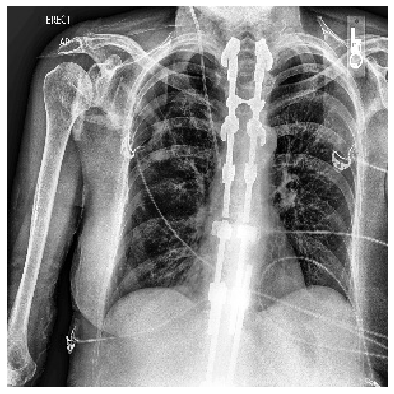

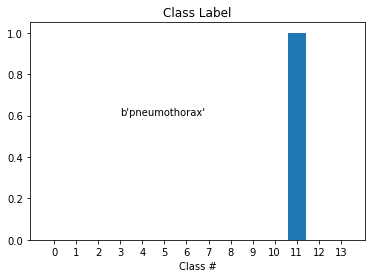

In [4]:
single_train_example = train_data.take(1)
for img, label, cls in single_train_example:
    train_image = img
    train_label = label
    train_class = cls
    
train_image = train_image[0]
train_label = train_label[0]
train_class = train_class[0]


showit.image(train_image)
plt.show()

plt.figure()
plt.bar(range(len(train_label)), train_label)
plt.xlabel('Class #')
plt.title('Class Label')
plt.xticks(range(14))
plt.text(3, 0.6, str(train_class.numpy()))
plt.show()

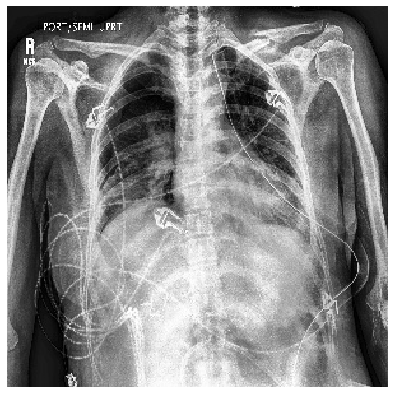

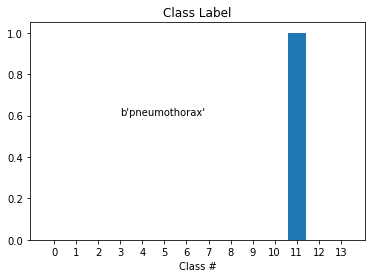

In [5]:
single_valid_example = valid_data.take(1)
for img, label, cls in single_valid_example:
    valid_image = img
    valid_label = label
    valid_class = cls
    
valid_image = valid_image[0]
valid_label = valid_label[0]
valid_class = valid_class[0]


showit.image(valid_image)
plt.show()

plt.figure()
plt.bar(range(len(valid_label)), valid_label)
plt.xlabel('Class #')
plt.title('Class Label')
plt.xticks(range(14))
plt.text(3, 0.6, str(valid_class.numpy()))
plt.show()

In [6]:
print(train_label)
print(valid_label)

tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(14,), dtype=float32)
tf.Tensor([0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0.], shape=(14,), dtype=float32)


# Restore Inception ResNet V2 From Keras

In [7]:
inception_res = InceptionResNetV2(include_top=False,
                                  weights='imagenet',
                                  input_shape=(299,299,3))

inception_res.trainable = False

# Restore AutoEncoders

In [8]:
from tensorflow.keras.models import load_model

def rename_layers(model, ext):
    for layer in model.layers:
        layer._name = layer.name + ext

def restore_models(path):
    restored_models = []
    models = os.listdir(path)
    for pos, model in enumerate(models):
        model_path = os.path.join(path,model)
        model = load_model(model_path)
        model._name = 'AE_{}'.format(pos)
        rename_layers(model, str(pos))
        
        model.trainable=False
        
        restored_models.append(model)
        
    return restored_models

In [9]:
AE_models = restore_models(models_dir)

In [10]:
AE_models[0].summary()

Model: "AE_0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 299, 299, 3)]     0         
_________________________________________________________________
sequential0 (Sequential)     (None, 150, 150, 32)      1536      
_________________________________________________________________
sequential_10 (Sequential)   (None, 75, 75, 32)        16384     
_________________________________________________________________
sequential_20 (Sequential)   (None, 38, 38, 32)        16384     
_________________________________________________________________
sequential_30 (Sequential)   (None, 19, 19, 16)        8192      
_________________________________________________________________
flatten0 (Flatten)           (None, 5776)              0         
_________________________________________________________________
dense0 (Dense)               (None, 1200)              6932400

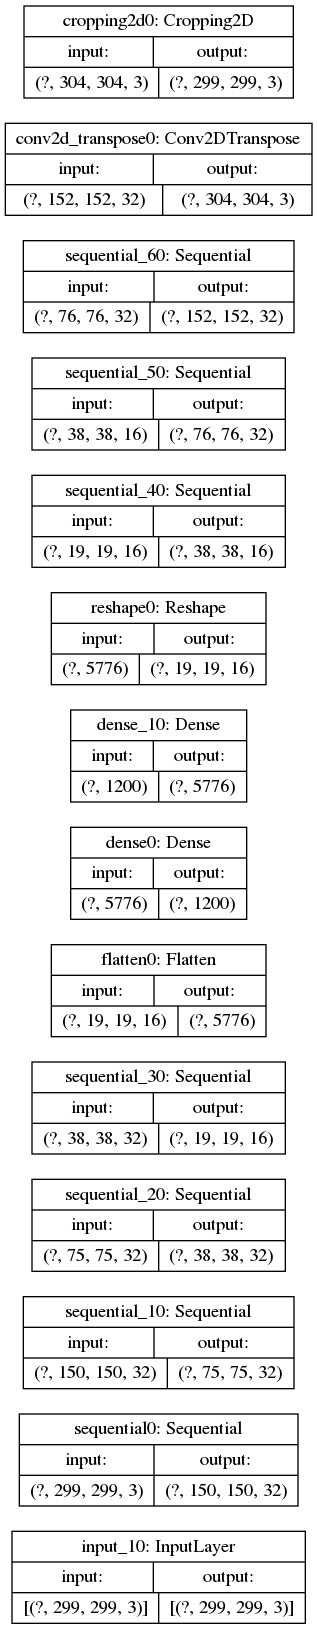

In [11]:
tf.keras.utils.plot_model(model=AE_models[0],
                          to_file='model.png',
                          show_shapes=True,
                          show_layer_names=True,
                          rankdir='LR',
                         dpi=96)

# Build Cheat Sheet

In [12]:
def cheatsheet():
    inputs = tf.keras.layers.Input(shape=[299,299,3])
    
    reconstruction_differences = []
    
    for model in AE_models:
        x = model(inputs)
        diff = tf.math.subtract(inputs, x)
        reconstruction_differences.append(diff)
        
    cheat_sheet = tf.keras.layers.Concatenate()(reconstruction_differences)
    return tf.keras.Model(inputs=inputs, outputs=cheat_sheet,name='cheatsheet')

In [13]:
for img, label, cls in single_train_example:
    train_image = img
    train_label = label
    train_class = cls

In [14]:
cheatsheet_generator = cheatsheet()

In [15]:
cheat_sheet = cheatsheet_generator(train_image)
cheat_sheet = tf.keras.layers.Flatten()(cheat_sheet)

In [16]:
transfer = inception_res(train_image)
transfer = tf.keras.layers.Flatten()(transfer)

In [21]:
model_input_ = tf.keras.layers.Concatenate()([cheat_sheet, transfer])

In [23]:
model_input_.shape

TensorShape([10, 634710])